Missed metric: pod_startup
Missed metric: create_to_schedule
Missed metric: schedule_to_watch


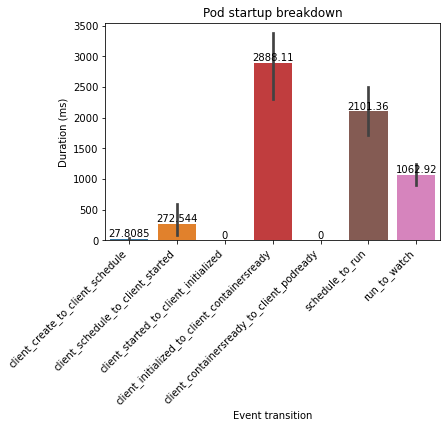

In [1]:
import matplotlib
import json
import seaborn
import pandas

file = "PodStartupLatency_PodStartupLatency_test_2021-12-15T16:53:51Z.json"
file = f"results/{file}"

j = json.loads(open(file, "r").read())

dataItems = j["dataItems"]

metrics = [
    "client_create_to_client_schedule",
    "client_schedule_to_client_started",
    "client_started_to_client_initialized",
    "client_initialized_to_client_containersready",
    "client_containersready_to_client_podready",
    # "create_to_schedule",  # time to write to etcd, pick up at scheduler and assign to node (write back to etcd)
    "schedule_to_run",  # time for node to pick up pod, pull image and get it running
    "run_to_watch",  # time from starting running for the observed status to be sent on a watch stream
    # "schedule_to_watch",  # time from it being scheduled until it is started and available to watch
    # "pod_startup",  # time for whole startup
]

for item in dataItems:
    if item["labels"]["Metric"] not in metrics:
        print(f"Missed metric: {item['labels']['Metric']}")

df = pandas.DataFrame()
for metric in metrics:
    found = False
    for item in dataItems:
        m = item["labels"]["Metric"]
        if m == metric:
            data = item["raw"]
            df[metric] = data
            found = True
    if not found:
        print(f"metric {metric} not found")

ax = seaborn.barplot(data=df)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Pod startup breakdown")
ax.set_xlabel("Event transition")
ax.set_ylabel("Duration (ms)")
fig = ax.get_figure()
fig.savefig("results/startup.pdf")
fig.savefig("results/startup.svg")
fig.savefig("results/startup.png")